In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import ast
from tqdm import tqdm
from icd9cms.icd9 import search

In [22]:
# Load and preprocess data
df = pd.read_csv("cleaned_data_of_pneumonia_patients 1.csv")
df.dropna(inplace=True)
df['ICD9_CODE_HISTORY'] = df['ICD9_CODE_HISTORY'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
icd9_dummies = df['ICD9_CODE_HISTORY'].str.join('|').str.get_dummies()
df = pd.concat([df.drop(columns=['ICD9_CODE_HISTORY']), icd9_dummies], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9607 entries, 0 to 10055
Columns: 3451 entries, SUBJECT_ID to V8801
dtypes: float64(1), int64(3445), object(5)
memory usage: 253.0+ MB


In [5]:
# One-hot encode categorical variables
categorical_columns = ['GENDER', 'ADMISSION_TYPE', 'ETHNICITY']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Prepare feature matrix (X) and target vector (y)
X = df.drop(columns=['Pneumonia', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DOB'])
y = df['Pneumonia']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
# Feature selection
selector = SelectKBest(f_classif, k=50)
X_selected = selector.fit_transform(X, y)

# Initialize logistic regression model
model = LogisticRegression(
    max_iter=1000,
    random_state=13,
    solver='saga',
    penalty='l2',
    C=np.float64(0.23357214690901212)
)

In [7]:
# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
y_probs = cross_val_predict(model, X_selected, y, cv=skf, method='predict_proba')[:, 1]
y_preds = cross_val_predict(model, X_selected, y, cv=skf)

# Calculate performance metrics
auc_score = roc_auc_score(y, y_probs)
conf_matrix = confusion_matrix(y, y_preds)
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

In [8]:
# Bootstrapping for AUC confidence interval
n_bootstraps = 1000
rng = np.random.default_rng(seed=13)
bootstrapped_aucs = []

for _ in range(n_bootstraps):
    indices = rng.choice(range(len(y)), size=len(y), replace=True)
    y_resampled = y.iloc[indices]
    y_probs_resampled = y_probs[indices]
    bootstrapped_aucs.append(roc_auc_score(y_resampled, y_probs_resampled))

# AUC confidence interval
lower_ci = np.percentile(bootstrapped_aucs, 2.5)
upper_ci = np.percentile(bootstrapped_aucs, 97.5)

Cross-validation folds: 5it [00:03,  1.49it/s]


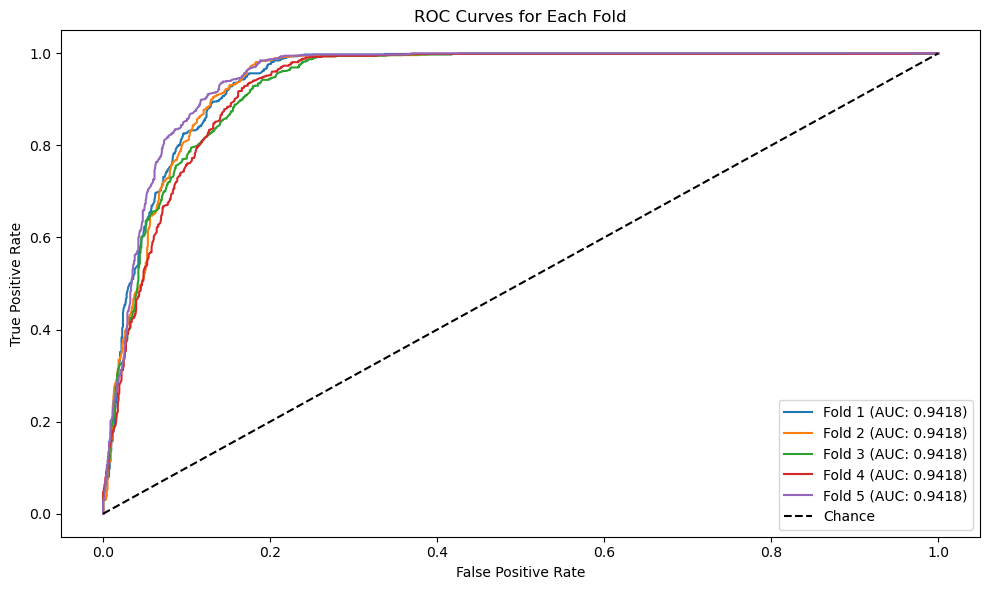

AUC: 0.9418 (95% CI: 0.9371 - 0.9463)
Sensitivity (Recall): 0.9364
Specificity: 0.8338
PPV (Precision): 0.7949
NPV: 0.9502


In [12]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
auc_scores = []
for fold, (train_index, test_index) in enumerate(
        tqdm(skf.split(X_selected, y), desc="Cross-validation folds", ncols=100)):
    X_train, X_test = X_selected[train_index], X_selected[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_test_probs = model.predict_proba(X_test)[:, 1]

    fold_auc = roc_auc_score(y_test, y_test_probs)
    auc_scores.append(fold_auc)

    fpr, tpr, _ = roc_curve(y_test, y_test_probs)
    plt.plot(fpr, tpr, label=f"Fold {fold + 1} (AUC: {auc_score:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Fold")
plt.legend(loc="best")
plt.tight_layout()
#plt.savefig("logistic_images/roc_curve_logistic.png")
plt.show()


# Print AUC and metrics
print(f"AUC: {auc_score:.4f} (95% CI: {lower_ci:.4f} - {upper_ci:.4f})")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"PPV (Precision): {ppv:.4f}")
print(f"NPV: {npv:.4f}")

In [13]:
# Fit the model to the full dataset
model.fit(X_selected, y)

# Get selected features
selected_features = pd.DataFrame(X, columns=df.drop(columns=['Pneumonia', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DOB']).columns).columns[selector.get_support()]

perm_importance = permutation_importance(
    model, X_selected, y, scoring='roc_auc', random_state=13, n_repeats=10
)

sorted_idx = perm_importance.importances_mean.argsort()[-20:]

def get_feature_label(feature_name):
    try:
        result = search(feature_name)
        return f"{result.code} {result.short_desc}" if result.short_desc else feature_name
    except:
        return feature_name


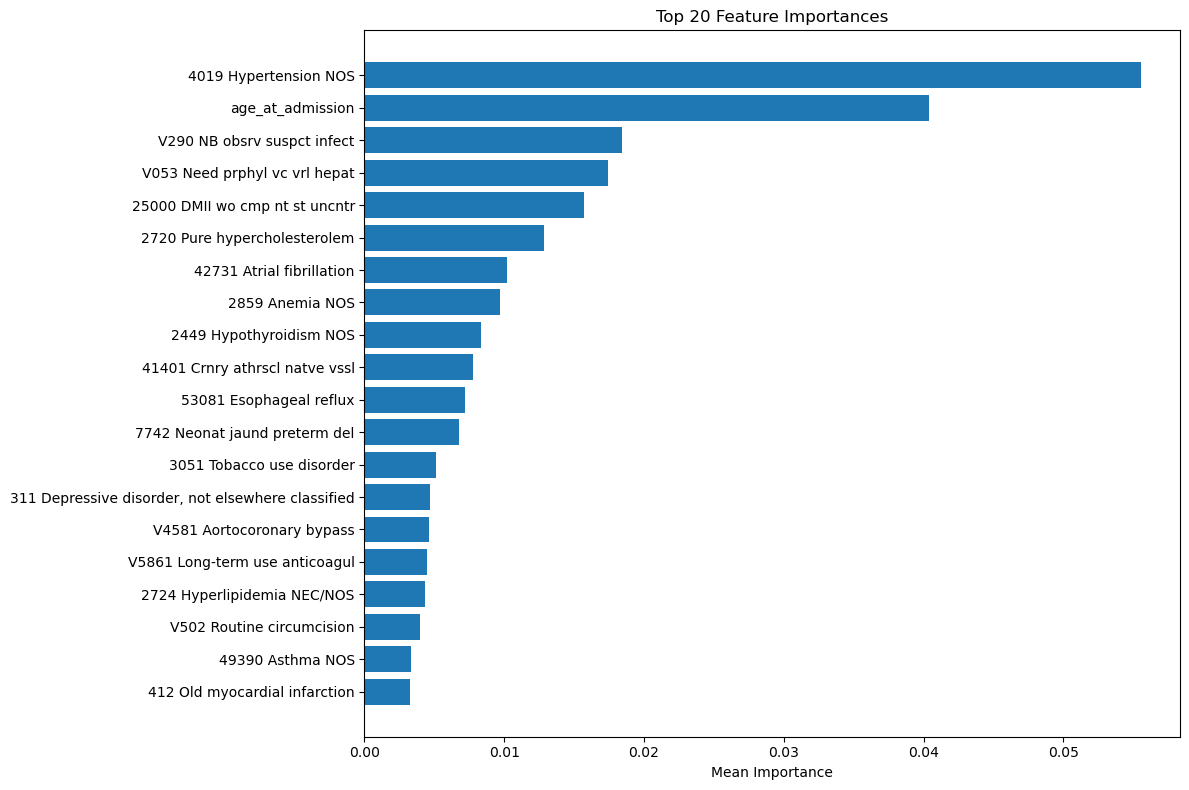

412 Old myocardial infarction: 0.0032
49390 Asthma NOS: 0.0033
V502 Routine circumcision: 0.0040
2724 Hyperlipidemia NEC/NOS: 0.0043
V5861 Long-term use anticoagul: 0.0045
V4581 Aortocoronary bypass: 0.0046
311 Depressive disorder, not elsewhere classified: 0.0047
3051 Tobacco use disorder: 0.0051
7742 Neonat jaund preterm del: 0.0068
53081 Esophageal reflux: 0.0072
41401 Crnry athrscl natve vssl: 0.0078
2449 Hypothyroidism NOS: 0.0084
2859 Anemia NOS: 0.0097
42731 Atrial fibrillation: 0.0102
2720 Pure hypercholesterolem: 0.0129
25000 DMII wo cmp nt st uncntr: 0.0157
V053 Need prphyl vc vrl hepat: 0.0174
V290 NB obsrv suspct infect: 0.0184
age_at_admission: 0.0404
4019 Hypertension NOS: 0.0556


In [14]:
plt.figure(figsize=(12, 8))
feature_names = [get_feature_label(selected_features[i]) for i in sorted_idx]
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names)
plt.xlabel("Mean Importance")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
#plt.savefig("logistic_images/feature_importance.png")
plt.show()

# Print feature importances
for i in sorted_idx:
    label = get_feature_label(selected_features[i])
    print(f"{label}: {perm_importance.importances_mean[i]:.4f}")

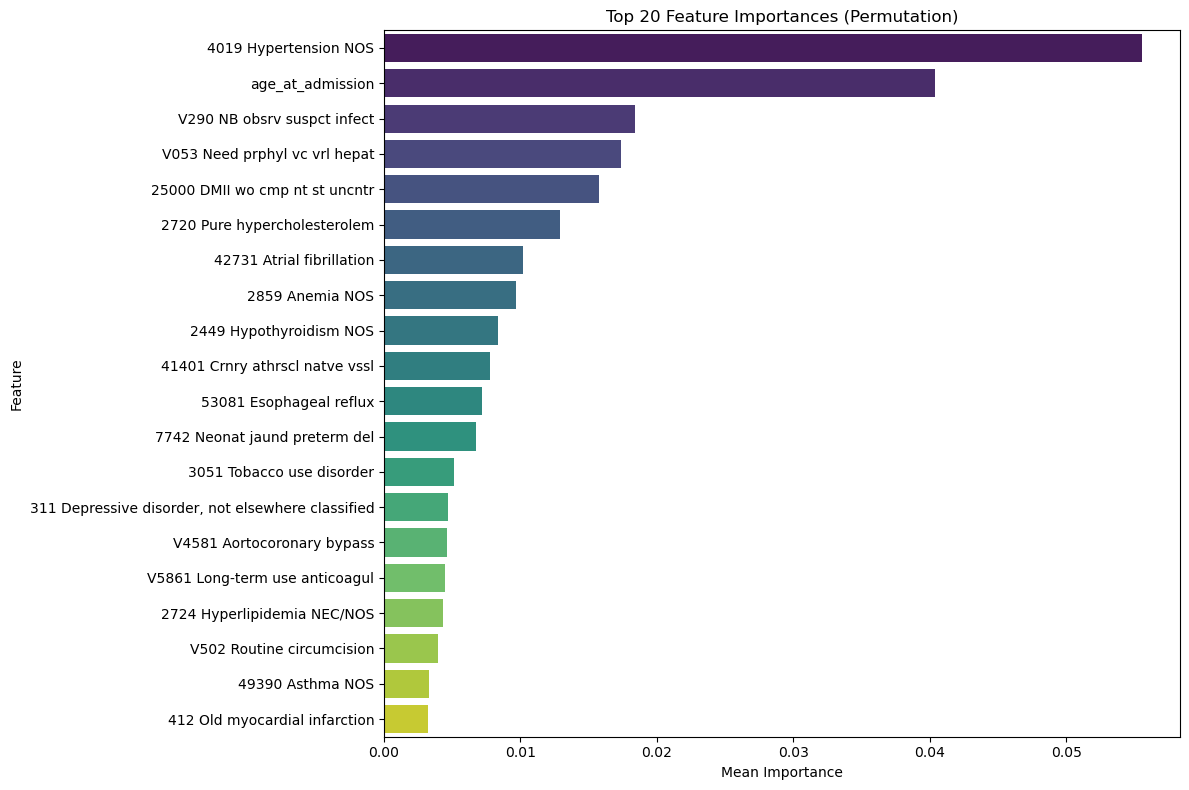

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare the data
top_n = 20
sorted_idx = np.argsort(perm_importance.importances_mean)[-top_n:][::-1]  # Top N features, descending
feature_names = [get_feature_label(selected_features[i]) for i in sorted_idx]
importances = perm_importance.importances_mean[sorted_idx]

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean Importance': importances
})

# Plot with Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(
    data=importance_df,
    x='Mean Importance',
    y='Feature',
    palette='viridis',
    orient='h'
)
plt.title("Top 20 Feature Importances (Permutation)")
plt.tight_layout()
plt.show()
